# Reduce-to-pole
#### as part of worked filters in NFIS PROJECT - CPRM-UFPR 
#### CPRM Intern researcher: Luizemara S. A. Szameitat (luizemara@gmail.com)

Last modified: Oct/2020
___
○ References:
Baranov, V., & Naudy, H. (1964). Numerical calculation of the formula of reduction to the magnetic pole. Geophysics, 29(1), 67-79.
Richard Blakely (1996). Potential Theory in Gravity & Magnetic Applications.
○ Acknowledgements: 
Thanks for the Geophysics Team on NFIS Project for productive discussions. I also would like to thank the PhD Geophysicist Julio C. S. O. Lyrio for improvements in the RTP for low latitudes.


In [1]:
import numpy as np
import scipy.fftpack
from math import radians, sin, cos, sqrt
import matplotlib.pyplot as plt

import seaborn as sb

### Functions

In [2]:
#Adapted Blakely functions

def DirCos(i, d, az):
    '''
    Function DirCos(incl, decl, azim), adapted from Blakely (1996)
    Parameters
    ----------
    i - magnetic inclination
    d - magnetic declination
    az - magnetic azimuth
    '''
    a = cos(radians(i))*cos(radians(d)-radians(az))
    b = cos(radians(i))*sin(radians(d)-radians(az))
    c = sin(radians(i)) 
    return a, b, c

def Kvalue(i, j, nx, ny, dkx, dky):
    '''
    Function Kvalue(i, j, nx, ny, dkx, dky), adapted from Blakely (1996)
    '''
    nyqx = nx / 2 + 1
    nyqy = ny / 2 + 1  
    kx = float() 
    ky = float() 
    if j <= nyqx:
        kx = (j-1) * dkx 
    else:
        kx = (j-nx-1) * dkx 
    if i <= nyqy:
        ky = (i-1) * dky 
    else:
        ky = (i-ny-1) * dky 
    return kx, ky

def NewVecLL(grid, nx, ny, dx, dy, fi1, fd1, mi1, md1, fi2, fd2, mi2, md2):    
    '''
    NewVecLL(grid, nx, ny, dx, dy, fi1, fd1, mi1, md1, fi2, fd2, mi2, md2)    
    NewVecLL() is adapted from NewVec() in Blakely (1996), with changes for low latitudes cases.    
    This function simulates the changing of magnetization direction    
    *** For reduce-to-pole results: mi2 = fi2 = 90    
    Parameters
    ----------
        nx, ny (int):
            number of elements in x and y directions
        grid - um array de duas dimensões contendo dados de campo total.
        dx, dy (int): 
            sampling distance in x and y 
        mi1, md1 - (degrees):
            Inclination and Declination of magnetization
        fi1, fd1 - (degrees):
            Earth's magnetic field inclination, declination
        mi2, md2 - (degrees):
            New inclination and declination of magnetization
        fi2, fd2 - (degrees)
            New inclination and declination of the local field
    '''
    c = 0
    nn = [ny, nx] # dimensões do array
    dkx = 2. * np.pi / (nx * dx)
    dky = 2. * np.pi / (ny * dy)         
    
    mx1, my1, mz1 = DirCos(mi1, md1, 0.) 
    fx1, fy1, fz1 = DirCos(fi1, fd1, 0.)
    mx2, my2, mz2 = DirCos(mi2, md2, 0.)
    fx2, fy2, fz2 = DirCos(fi2, fd2, 0.)    
        
    # Step 1) Fourier Transform 
    gridfft = scipy.fftpack.fft2(grid)       
    gridfft = np.reshape(gridfft, nx*ny) # reshaping to 1D vector 
          
    # Step 2.A) Phase filter (original routine, valid to -20 > latitude and latitude > 20)
    if mi1 < -20 or mi1 > 20:
        for j in range (1, nx+1):
            for i in range (1, ny+1):
                ij = (j-1) * ny + i 
                if ij == 1:                
                    cphase = 0.0
                else:
                    kx, ky = Kvalue(i, j, nx, ny, dkx, dky) # ** funcao Kvalue 
                    k = sqrt(kx**2 + ky**2)                        
                    thetam1 = complex(mz1, (kx*mx1 + ky*my1) / k)
                    thetaf1 = complex(fz1, (kx*fx1 + ky*fy1) / k)
                    thetam2 = complex(mz2, (kx*mx2 + ky*my2) / k)
                    thetaf2 = complex(fz2, (kx*fx2 + ky*fy2) / k) 
                    cphase = thetam2 * thetaf2 / (thetam1 * thetaf1) 
                       
                # Filtering each item in the grid
                gridfft[ij-1] = gridfft[ij-1]*cphase   
                
    # Step 2.B) Phase filter (special case for low latitudes)
    elif mi1 > -21 and mi1 < 21: 
        if mi1 < 0:
            c = -90-mi1
        else:
            c = 90-mi1            
        for j in range (1, nx+1):
            for i in range (1, ny+1):
                ij = (j-1) * ny + i                
                if ij == 1:                
                    cphase = 0.0
                    cphase2 = 0.0                    
                else:
                    kx, ky = Kvalue(i, j, nx, ny, dkx, dky)
                    
                    k = sqrt(kx**2 + ky**2)                        
                    thetam1 = complex(mz1, (kx*mx1 + ky*my1) / k)
                    thetaf1 = complex(fz1, (kx*fx1 + ky*fy1) / k)
                    thetam2 = complex(mz2, (kx*mx2 + ky*my2) / k)
                    thetaf2 = complex(fz2, (kx*fx2 + ky*fy2) / k) 
                    cphase = thetam2 * thetaf2 / (thetam1 * thetaf1) 
                    
                    # special case for low latitudes
                    cx, cy, cz = DirCos(c, md1, 0.)                     
                    thetam3 = complex(mz1, (-kx*mx1 - ky*my1) / k)
                    thetac1 = complex(cz, (kx*cx + ky*cy) / k)
                    thetac2 = complex(cz, (-kx*cx - ky*cy) / k)                    
                    cphase2 = cphase * (thetam1 * thetam3 / (thetac1 * thetac2))                     
                    #                    
                # Filtering each grid item
                gridfft[ij-1] = gridfft[ij-1] * cphase2
            
    # Step 3) Fourier Inverse transform     
    gridfft = np.reshape(gridfft, (ny, nx)) # returning to the 2D shape 
    gridifft = scipy.fftpack.ifft2(gridfft)        
    grid = gridifft.real #getting only the real part
    
    return grid



### RTP filtering 
#### Input data
Read the CSV file containing a gridded data. The file columns must contain coordinates in ground units (x,y) and the physical property (z). In this version, the routine do not work with dummies.

In [3]:
#XYZ grid reading (CSV format, no header, no line numbers)
filename = 'https://raw.githubusercontent.com/lszam/cprm-nfis/main/data/magcwin_bd250.csv'
#reading csv columns - coordinates and physical property
csv_values = np.genfromtxt(filename, delimiter=",") #choose the delimiter (the Brazilian defaut is ";")
x = csv_values[:,0]
y = csv_values[:,1]
z = csv_values[:,2]

In [4]:
#Getting x and y values as lists and avoiding repeated items
xnodes, ynodes =[], []
[xnodes.append(item) for item in x if not xnodes.count(item)]
[ynodes.append(item) for item in y if not ynodes.count(item)]
nx = len(xnodes)
ny = len(ynodes)

#Preparing the data: arranging the physical property into a matrix 
Z = np.array(z) # data from list to array 
grid_tfa = np.reshape(Z, (ny, nx))  
dX, dY = np.abs(xnodes[0]-xnodes[1]), np.abs(ynodes[0]-ynodes[1]) # cell size
xgrid, ygrid = np.meshgrid(xnodes, ynodes) 

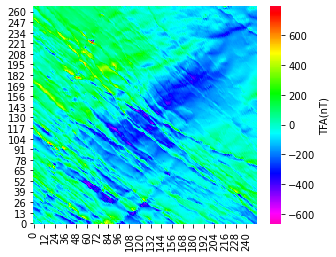

In [5]:
#Plotting input grid 
plt.figure(figsize=(5, 4))
sb_plot1 = sb.heatmap(grid_tfa, cmap="gist_rainbow_r", cbar_kws={'label': 'TFA(nT)'})
sb_plot1.invert_yaxis()

#### Parameters
Inclination and declination parameters for the body and the ambient field. The original *NewVec()* function in Blakely (1996) was designed to emcompassing other cases of magnetization besides the RTP (Baranov and Naudy, 1964). For RTP, we consider that remnance is negligible, so the initial parameters for magnetization follow the ambient field orientation. 
For developing this study, we have used an area in the Paraná Shield (Brazil) that emcompasses the Cunhaporanga Granitic Complex and part of the Ponta Grossa mafic dykes swarm. In that case, parameters for this area were estimated as declination = -18.3 and inclination = -33.7.

In [6]:
#Parameters
fi1 = int(-33.7)
fd1 = int(-18.3)
mi1 = int(-33.7)
md1 = int(-18.3)
fi2 = 90 #rtp
mi2 = 90 #rtp
fd2 = 0 #rtp
md2 = 0 #rtp

#### RTP filter

In [7]:
#Reduce-to-pole filtering
grid_rtp = NewVecLL(grid_tfa, nx, ny, dX, dY, fi1, fd1, mi1, md1, fi2, fd2, mi2, md2)

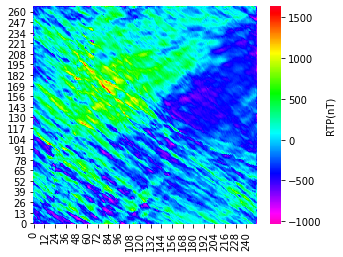

In [8]:
#Plotting output grid
plt.figure(figsize=(5, 4))
sb_plot2 = sb.heatmap(grid_rtp, cmap="gist_rainbow_r", cbar_kws={'label': 'RTP(nT)'})
sb_plot2.invert_yaxis()

In [9]:
#Other outputs

In [10]:
#Save txt file
grid_output = np.reshape(grid_rtp, (nx*ny))
np.savetxt(str('magnetics_rtp.txt'),np.c_[x,y,grid_output])
#Save output image
fig = sb_plot2.get_figure()
fig.savefig("magnetics_rtp.png")